In [ ]:
%cd /content/drive/MyDrive/ri/code/data

/content/drive/MyDrive/ri/code/data


In [ ]:
import re
import itertools

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from collections import Counter

#Data Understanding and Preparation

## Import Libraries and Load Data


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ri/code/data/A1_standard.csv')
print(df.head())

                                                text     class
0  According to Gran , the company has no plans t...   neutral
1  Technopolis plans to develop in stages an area...   neutral
2  The international electronic industry company ...  negative
3  For the last quarter of 2010 , Componenta 's n...  positive
4  In the third quarter of 2010 , net sales incre...  positive


## Data Information and Missing Values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2758 entries, 0 to 2757
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2758 non-null   object
 1   class   2758 non-null   object
dtypes: object(2)
memory usage: 43.2+ KB


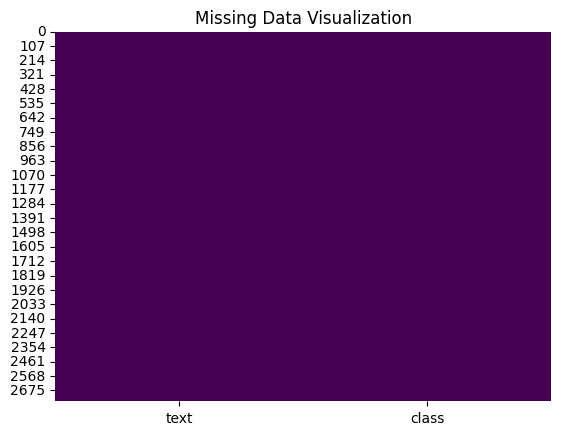

In [ ]:
df.info()

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Visualization')
plt.show()


In [ ]:
# Handle Missing Values, given there are none but still
if df['text'].isnull().sum() > 0:
    df['text'] = df['text'].fillna('no_text')
    # df.dropna(subset=['text'], inplace=True)

## Remove Noise, Tokenize, and Normalize Text


In [ ]:
# Ensure nltk resources are downloaded (first time run)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Improved dictionary for replacing abbreviations and unclear words
replacement_dict = {
    'eur': 'euro',
    'mn': 'million',
    'mln': 'million',
    'oyj': 'company',
    'pct': 'percent',
    'hel': 'Helsinki',
    'eurm': 'euro million'  # Assuming eurm means euro million
}

def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Replace hyphens with spaces (to maintain semantic integrity)
    text = re.sub(r'-', ' ', text)
    # Remove punctuation except for periods (which can help in maintaining sentence boundaries)
    text = re.sub(r'[^\w\s\.]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Lemmatization (Avoid lemmatizing negations to preserve their form)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) if not plural_related(word) else word for word in tokens]
    # Replace words based on dictionary, preserving semantic integrity
    tokens = [replacement_dict.get(word, word) for word in tokens]
    # Remove single characters that are not meaningful (adjust according to your needs)
    tokens = [word for word in tokens if len(word) > 1 or word in ['a', 'i']]
    # Join tokens and handle multiple spaces, especially around periods.
    processed_text = ' '.join(tokens).replace(' .', '.')
    # Remove trailing period if present
    if processed_text.endswith('.'):
        processed_text = processed_text[:-1]
    return processed_text

def plural_related(word):
    # Simple function to handle common plural forms; this could be expanded.
    if word.endswith('s'):
        return True
    return False

# Example of applying the function to a DataFrame column
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Display the original and cleaned text columns to verify changes
print(df[['text', 'cleaned_text']].head())

                                                text  \
0  According to Gran , the company has no plans t...   
1  Technopolis plans to develop in stages an area...   
2  The international electronic industry company ...   
3  For the last quarter of 2010 , Componenta 's n...   
4  In the third quarter of 2010 , net sales incre...   

                                        cleaned_text  
0  according to gran the company has no plans to ...  
1  technopolis plans to develop in stages an area...  
2  the international electronic industry company ...  
3  for the last quarter of 2010 componenta net sa...  
4  in the third quarter of 2010 net sales increas...  


In [ ]:
for i in df['cleaned_text'].head(10):
    print(i)

according to gran the company has no plans to move all production to russia although that is where the company is growing
technopolis plans to develop in stages an area of no less than 100000 square meters in order to host companies working in computer technologies and telecommunications the statement said
the international electronic industry company elcoteq has laid off tens of employees from its tallinn facility contrary to earlier layoffs the company contracted the ranks of its office workers the daily postimees reported
for the last quarter of 2010 componenta net sales doubled to eur131m from eur76m for the same period a year earlier while it moved to a zero pre tax profit from a pre tax loss of eur7m
in the third quarter of 2010 net sales increased by 5.2 to euro 205.5 million and operating profit by 34.9 to euro 23.5 million
operating profit rose to euro 13.1 million from euro 8.7 million in the corresponding period in 2007 representing 7.7 of net sales
teliasonera tlsn said the

## Display Cleaned Text


In [ ]:
print(df[['text', 'cleaned_text']].head())

                                                text  \
0  According to Gran , the company has no plans t...   
1  Technopolis plans to develop in stages an area...   
2  The international electronic industry company ...   
3  For the last quarter of 2010 , Componenta 's n...   
4  In the third quarter of 2010 , net sales incre...   

                                        cleaned_text  
0  according to gran the company has no plans to ...  
1  technopolis plans to develop in stages an area...  
2  the international electronic industry company ...  
3  for the last quarter of 2010 componenta net sa...  
4  in the third quarter of 2010 net sales increas...  


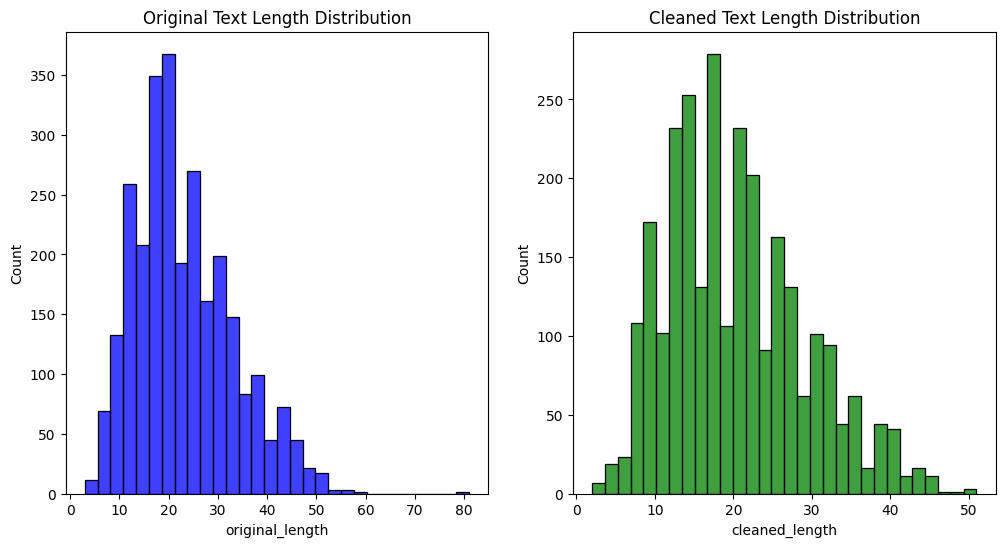

In [ ]:
# Visualize the text length distribution before and after cleaning
df['original_length'] = df['text'].apply(lambda x: len(x.split()))
df['cleaned_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df['original_length'], bins=30, ax=ax[0], color='blue')
ax[0].set_title('Original Text Length Distribution')
sns.histplot(df['cleaned_length'], bins=30, ax=ax[1], color='green')
ax[1].set_title('Cleaned Text Length Distribution')
plt.show()

In [ ]:
df.to_csv('processed_data.csv', index=False)

# EDA

## Text Lenghts

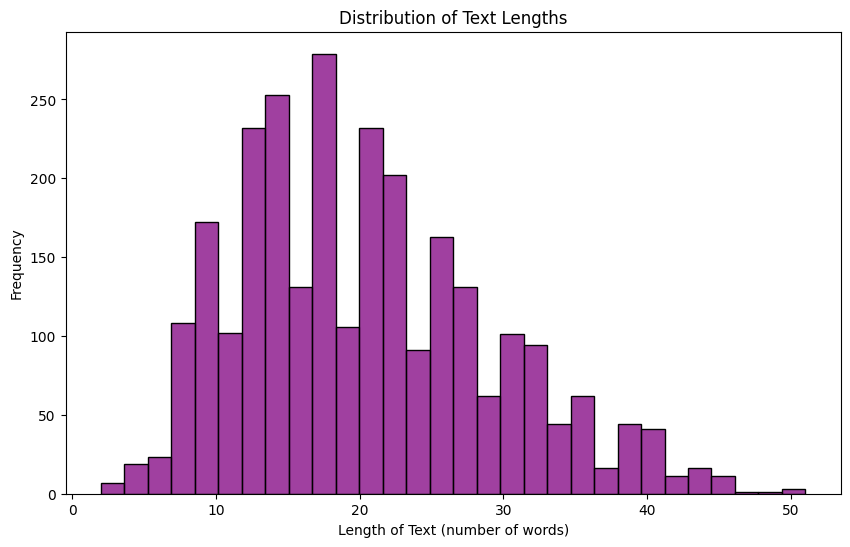

In [ ]:
# Visualize the distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['cleaned_length'], bins=30, color='purple')
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text (number of words)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'cleaned_text' is the column with the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['cleaned_text'])

# Summing up the counts of each vocabulary word
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Extracting the top 100 words
top_words = words_freq[:60]

# Converting to DataFrame for better visualization
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Printing the top 100 words with their frequencies
top_words_df

,Word,Frequency
0,the,3457
1,of,1843
2,in,1701
3,and,1478
4,to,1440
5,million,712
6,euro,686
7,for,654
8,company,618
9,is,530


## Calculate and Visualize the Frequency of Individual Words


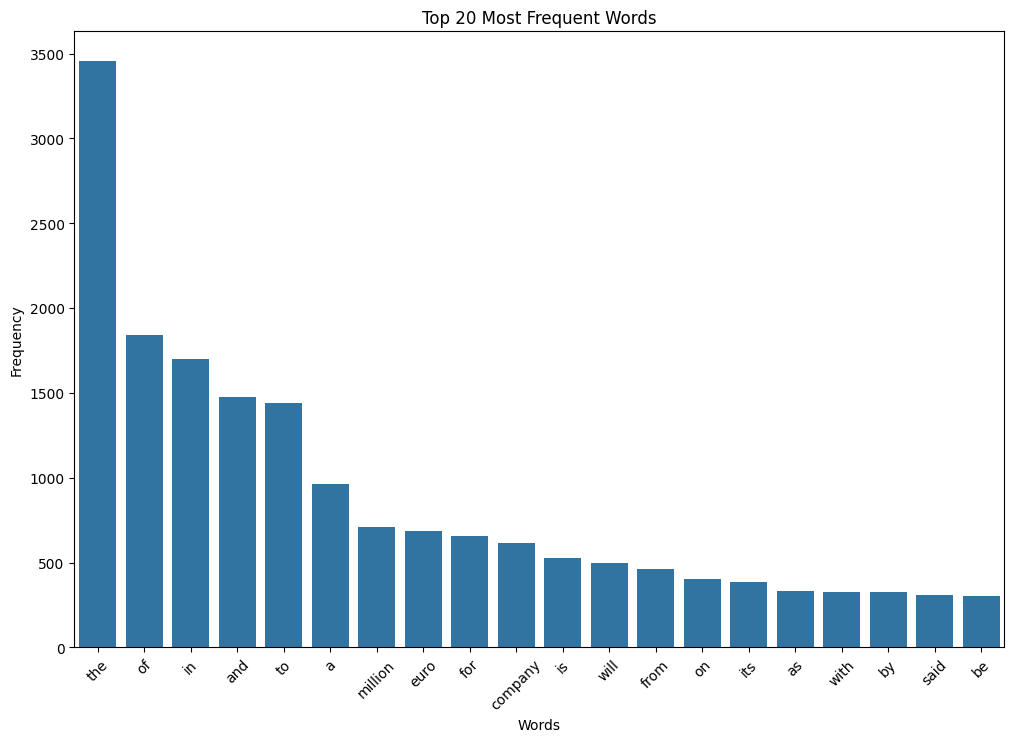

In [ ]:
from collections import Counter
import itertools

# Count frequencies of all words in the cleaned text
all_words = list(itertools.chain(*df['cleaned_text'].str.split()))
word_counts = Counter(all_words)

# Display the top 20 most common words
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

# Corrected code to visualize the Top 20 Most Frequent Words
plt.figure(figsize=(12, 8))
sns.barplot(x=list(words), y=list(counts))  # Explicitly name the parameters
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

## Visualize the Sentiment Distribution


In [ ]:
print(df.columns)

Index(['text', 'class', 'cleaned_text', 'original_length', 'cleaned_length'], dtype='object')


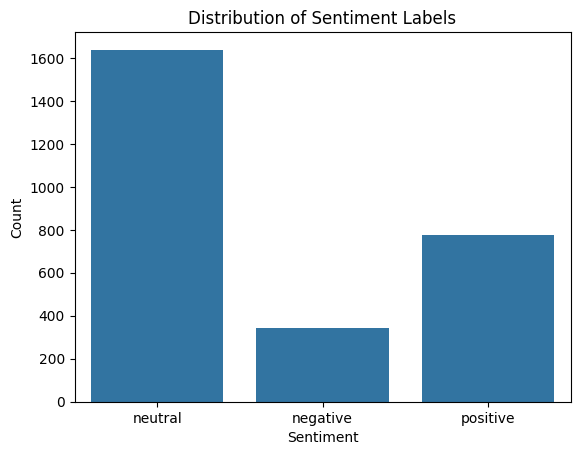

Ratio of Positive to Negative Samples: 2.26


In [ ]:
sns.countplot(x=df['class'])
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Calculate class imbalance ratio
positive_count = df[df['class'] == 'positive'].shape[0]
negative_count = df[df['class'] == 'negative'].shape[0]
ratio = positive_count / negative_count
print(f"Ratio of Positive to Negative Samples: {ratio:.2f}")

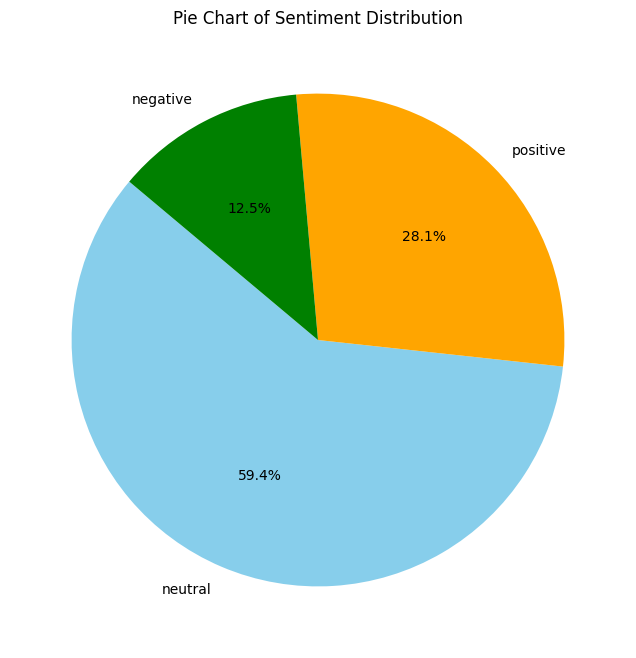

In [ ]:
sentiment_counts = df['class'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange', 'green'])
plt.title('Pie Chart of Sentiment Distribution')
plt.show()

## Generate Word Clouds for Each Sentiment Category


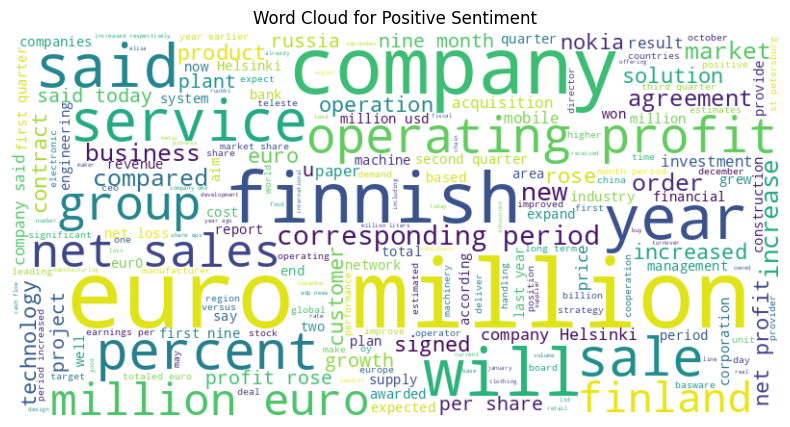

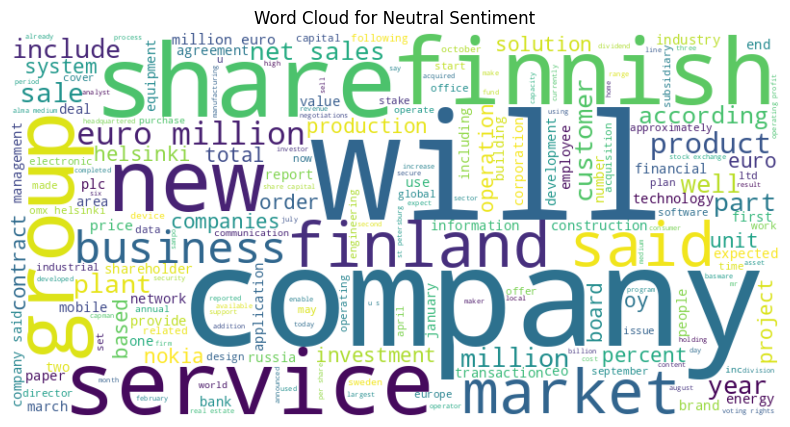

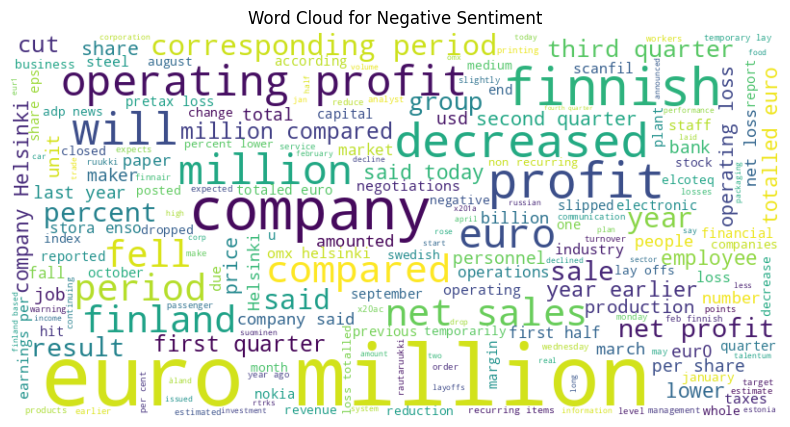

In [ ]:
from wordcloud import WordCloud

def generate_wordcloud(data, title):
    text = ' '.join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

for sentiment in ['positive', 'neutral', 'negative']:
    generate_wordcloud(df[df['class'] == sentiment]['cleaned_text'], f'Word Cloud for {sentiment.capitalize()} Sentiment')

## Analyze the Frequency of Bigrams

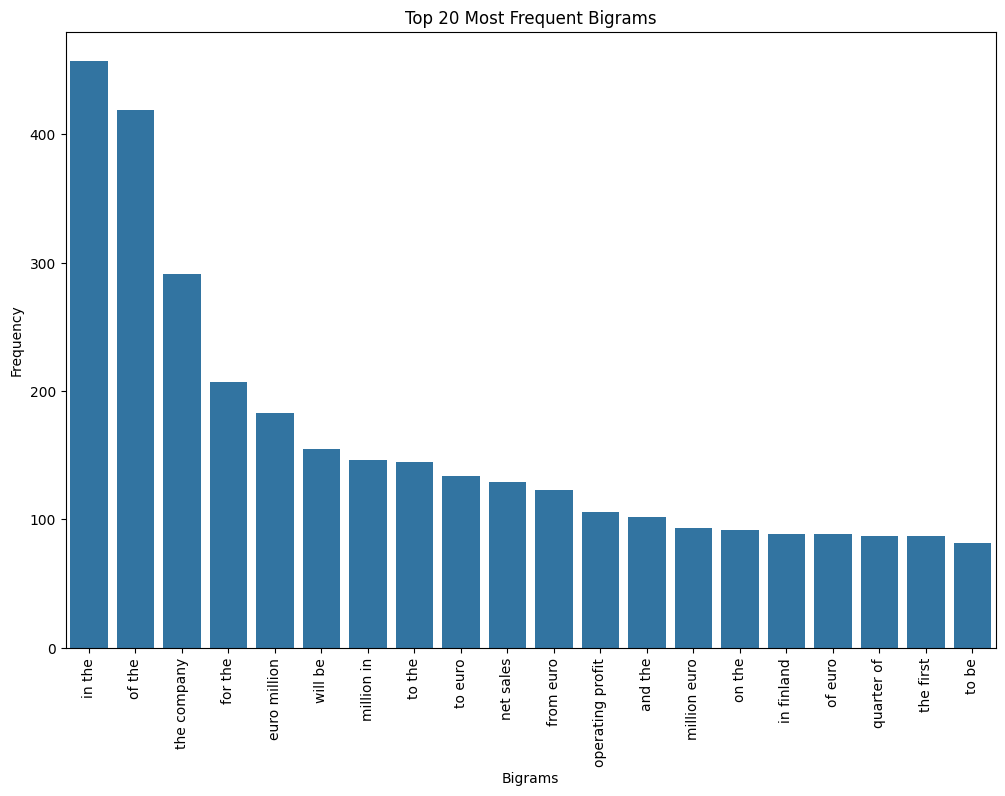

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2, 2))
bigrams = vectorizer.fit_transform(df['cleaned_text'])
bigram_counts = bigrams.sum(axis=0)
bigram_frequencies = [(word, bigram_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
bigram_frequencies = sorted(bigram_frequencies, key=lambda x: x[1], reverse=True)[:20]

# Plotting the Top 20 Bigrams

words, counts = zip(*bigram_frequencies)
plt.figure(figsize=(12, 8))
sns.barplot(x=list(words), y=list(counts))
plt.title('Top 20 Most Frequent Bigrams')
plt.xticks(rotation=90)
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.show()

## Analyze the Frequency of Trigrams

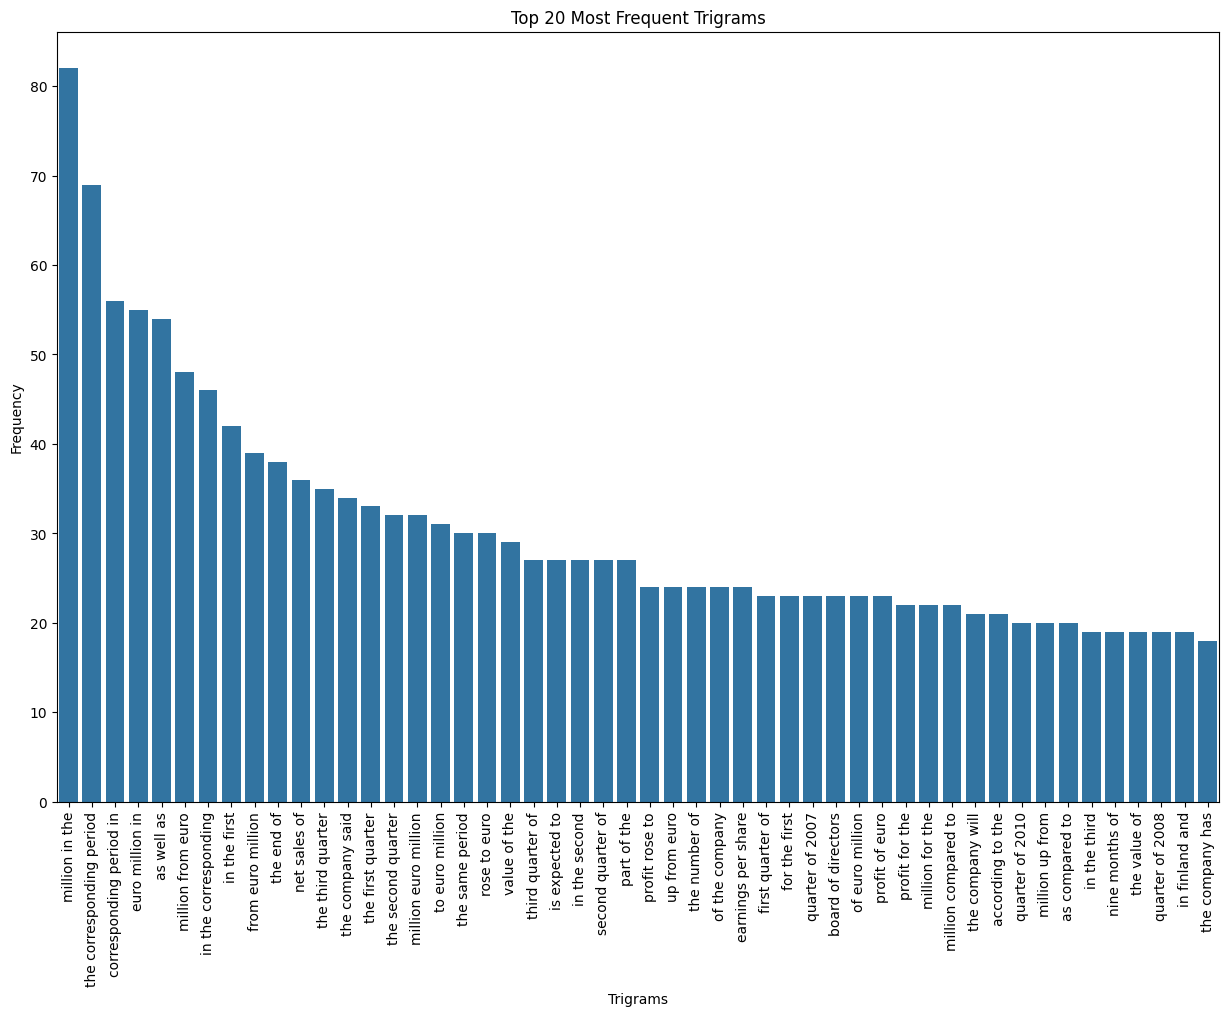

In [ ]:
vectorizer = CountVectorizer(ngram_range=(3, 3))
trigrams = vectorizer.fit_transform(df['cleaned_text'])
trigram_counts = trigrams.sum(axis=0)
trigram_frequencies = [(word, trigram_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
trigram_frequencies = sorted(trigram_frequencies, key=lambda x: x[1], reverse=True)[:50]

# Plotting the top 20 trigrams
words, counts = zip(*trigram_frequencies)
plt.figure(figsize=(15, 10))
sns.barplot(x=list(words), y=list(counts))
plt.title('Top 20 Most Frequent Trigrams')
plt.xticks(rotation=90)
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.show()


## Co-Occurrence Networks for Words in the Text

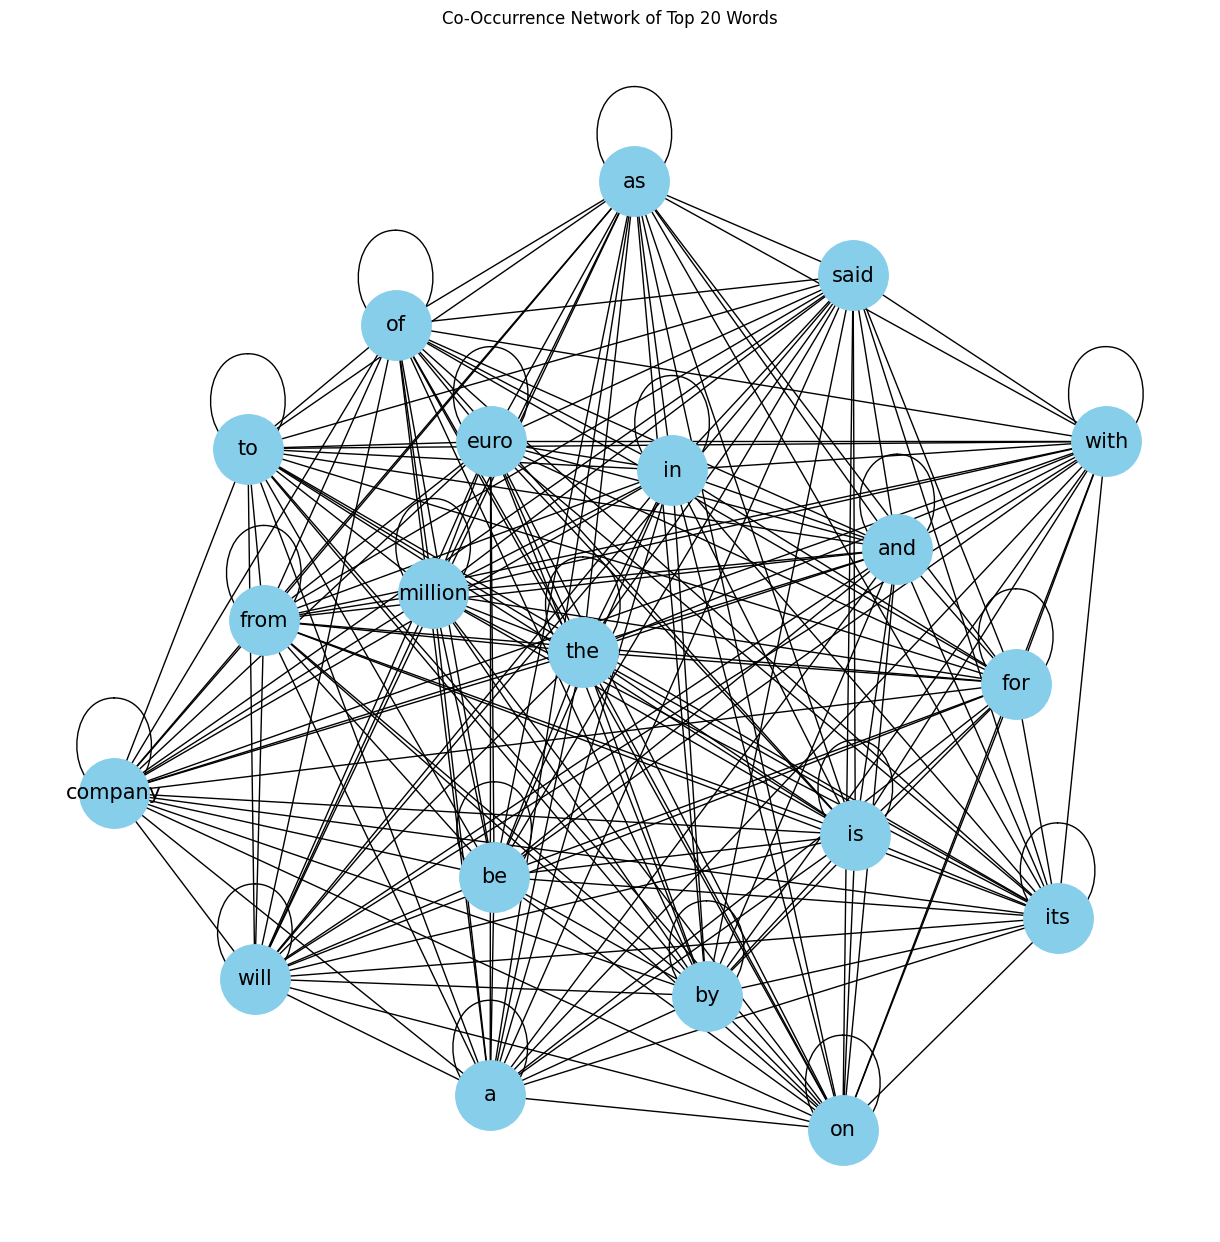

In [ ]:
import networkx as nx
from itertools import combinations

def create_cooccurrence_matrix(line, vocab):
    co_occurrences = nx.Graph()
    for word1, word2 in combinations(line.split(), 2):
        if word1 in vocab and word2 in vocab:
            if co_occurrences.has_edge(word1, word2):
                co_occurrences[word1][word2]['weight'] += 1
            else:
                co_occurrences.add_edge(word1, word2, weight=1)
    return co_occurrences

# Create a graph for the top 20 most frequent words
top_words = set([word for word, count in word_counts.most_common(20)])
co_occurrence_graph = nx.Graph()

for line in df['cleaned_text']:
    g = create_cooccurrence_matrix(line, top_words)
    co_occurrence_graph = nx.compose(co_occurrence_graph, g)


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(co_occurrence_graph, k=0.5)  # k regulates the distance between nodes
nx.draw(co_occurrence_graph, pos, with_labels=True, node_color='skyblue', node_size=2500, edge_color='k', linewidths=1, font_size=15)
plt.title('Co-Occurrence Network of Top 20 Words')
plt.show()


## Saving Data

In [ ]:
for i in df['cleaned_text']:
    print(i)

according to gran the company has no plans to move all production to russia although that is where the company is growing
technopolis plans to develop in stages an area of no less than 100000 square meters in order to host companies working in computer technologies and telecommunications the statement said
the international electronic industry company elcoteq has laid off tens of employees from its tallinn facility contrary to earlier layoffs the company contracted the ranks of its office workers the daily postimees reported
for the last quarter of 2010 componenta net sales doubled to eur131m from eur76m for the same period a year earlier while it moved to a zero pre tax profit from a pre tax loss of eur7m
in the third quarter of 2010 net sales increased by 5.2 to euro 205.5 million and operating profit by 34.9 to euro 23.5 million
operating profit rose to euro 13.1 million from euro 8.7 million in the corresponding period in 2007 representing 7.7 of net sales
teliasonera tlsn said the

In [ ]:
# Save the DataFrame to a new CSV file
df.to_csv('eda_data.csv', index=False)

In [ ]:
# Display the first few rows of the DataFrame
print(df.head())

# Display general information about the DataFrame
print(df.info())

# Display summary statistics for numerical columns
print(df.describe())

# Display summary statistics for categorical columns
print(df.describe(include=['object']))

                                                text     class  \
0  According to Gran , the company has no plans t...   neutral   
1  Technopolis plans to develop in stages an area...   neutral   
2  The international electronic industry company ...  negative   
3  For the last quarter of 2010 , Componenta 's n...  positive   
4  In the third quarter of 2010 , net sales incre...  positive   

                                        cleaned_text  original_length  \
0  according to gran the company has no plans to ...               25   
1  technopolis plans to develop in stages an area...               31   
2  the international electronic industry company ...               36   
3  for the last quarter of 2010 componenta net sa...               39   
4  in the third quarter of 2010 net sales increas...               29   

   cleaned_length  
0              22  
1              29  
2              33  
3              37  
4              24  
<class 'pandas.core.frame.DataFrame'>
RangeI

# Sentiment Analysis Model Development

## Loading

In [ ]:
df = pd.read_csv('eda_data.csv')

In [ ]:
# Function to create and return the Bag of Words DataFrame
def create_bow_representation(texts, use_tfidf=False, max_features=100):
    # Select the type of Vectorizer
    vectorizer = TfidfVectorizer(max_features=max_features) if use_tfidf else CountVectorizer(max_features=max_features)

    # Fit and transform the text data
    X = vectorizer.fit_transform(texts)

    # Convert to DataFrame for easier handling
    feature_names = vectorizer.get_feature_names_out()
    df_bow = pd.DataFrame(X.toarray(), columns=feature_names)

    return df_bow, feature_names

# Example usage (You can remove or comment out this example usage in production)
df_bow, feature_names = create_bow_representation(df['cleaned_text'], use_tfidf=False, max_features=50)

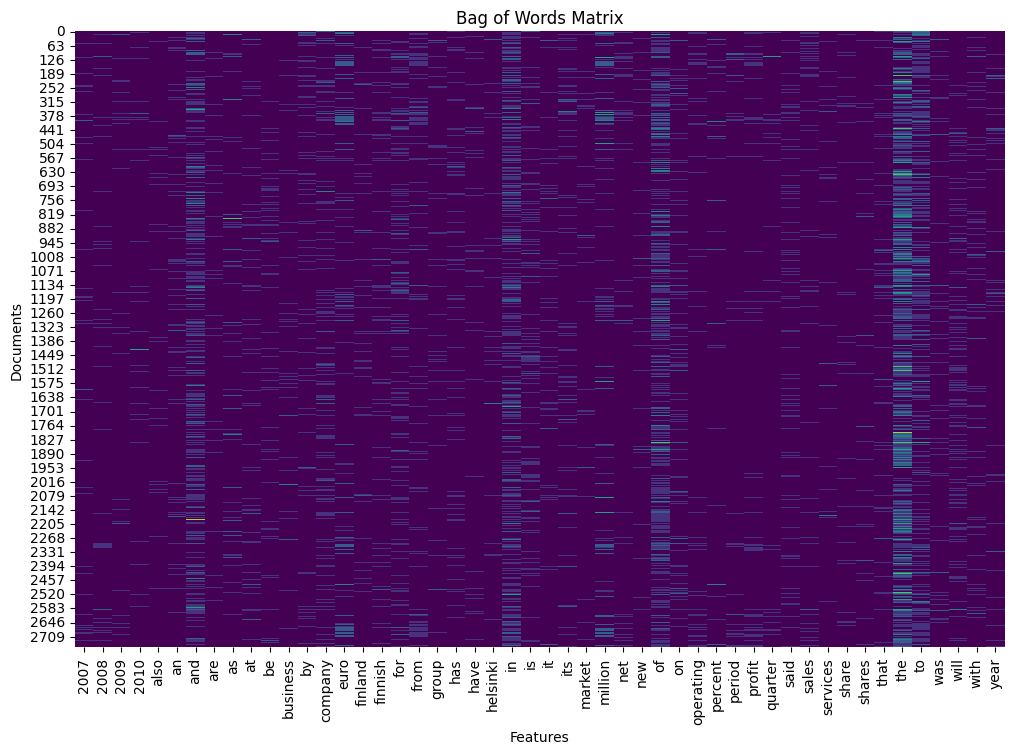

In [ ]:
def visualize_bow(df_bow, feature_names, annotate=False):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_bow, annot=annotate, cmap='viridis', cbar=False, xticklabels=feature_names)
    plt.title('Bag of Words Matrix')
    plt.xlabel('Features')
    plt.ylabel('Documents')
    plt.show()

visualize_bow(df_bow, feature_names, annotate=False)

#Models

##Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score

# Assuming 'df' is your DataFrame and it has been preprocessed accordingly

# Vectorizing the cleaned text
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['class']

# Encoding class labels if they are not already numeric
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=35476648)

In [ ]:
# Training a Logistic Regression model with default settings
model = LogisticRegression(max_iter=1000)  # Increase max_iter if convergence issues arise
model.fit(X_train, y_train)

# Evaluating the model using predictions
predictions = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, predictions))

# Getting probability scores for ROC AUC calculation
probabilities = model.predict_proba(X_test)

# Calculating ROC AUC score
# Ensure y_test and probabilities[:, 1] (probabilities for the positive class) are used
auc_score = roc_auc_score(y_test, probabilities, multi_class='ovr')  # 'ovr' stands for One-vs-Rest
print(f"ROC AUC Score: {auc_score:.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.30      0.42        54
           1       0.75      0.96      0.84       342
           2       0.72      0.42      0.53       156

    accuracy                           0.74       552
   macro avg       0.73      0.56      0.60       552
weighted avg       0.74      0.74      0.71       552

ROC AUC Score: 0.85


##SVM

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Ensure no NaN values in the cleaned_text column
df['cleaned_text'] = df['cleaned_text'].fillna('')

# Vectorizing the cleaned text
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['class']

# Encoding class labels if they are not already numeric
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=35476648)


In [ ]:
# Setting up the SVC model with balanced class weights and enabling probability estimates
model = SVC(class_weight='balanced', probability=True)
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1)
grid_search.fit(X_train, y_train)

# Evaluating the best model from grid search
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)  # Get class probabilities for AUC

# Calculating the ROC AUC score
auc_score = roc_auc_score(y_test, probs, multi_class='ovr')  # Adjust multi_class parameter as needed based on label type

# Printing evaluation results
print("Classification Report:")
print(classification_report(y_test, predictions))
print(f"ROC AUC Score: {auc_score:.2f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.41      0.49        54
           1       0.79      0.92      0.85       342
           2       0.72      0.54      0.62       156

    accuracy                           0.76       552
   macro avg       0.71      0.62      0.65       552
weighted avg       0.75      0.76      0.75       552

ROC AUC Score: 0.87


##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Assuming 'df' is your DataFrame and it has been preprocessed accordingly

# Vectorizing the cleaned text
vectorizer = TfidfVectorizer(max_features=1000)  # You can experiment with the number of features
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['class']

# Encoding class labels if they are not already numeric
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=35476648)


In [ ]:
# Setting up the Random Forest classifier
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Parameters for GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30],        # Maximum number of levels in each decision tree
    'min_samples_split': [2, 5, 10],  # Minimum number of data points placed in a node before the node is split
    'min_samples_leaf': [1, 2, 4]     # Minimum number of data points allowed in a leaf node
}

# Setting up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluating the best model from grid search
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)  # Get class probabilities

# Calculating the ROC AUC score
auc_score = roc_auc_score(y_test, probs, multi_class='ovr')  # Adjust multi_class as needed

# Printing evaluation results
print("Classification Report:")
print(classification_report(y_test, predictions))
print(f"ROC AUC Score: {auc_score:.2f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.43      0.53        54
           1       0.76      0.95      0.85       342
           2       0.74      0.44      0.55       156

    accuracy                           0.76       552
   macro avg       0.74      0.61      0.64       552
weighted avg       0.75      0.76      0.73       552

ROC AUC Score: 0.83


##CNN, LSTM, BiLSTM

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report

# Sample DataFrame with text and labels
# df = pd.read_csv("path_to_your_dataset.csv")

# Preparing the text data
texts = df['cleaned_text'].values
labels = df['class'].values

# Tokenizing texts
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=200)

# Encoding labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
y = tf.keras.utils.to_categorical(y, num_classes=len(encoder.classes_))

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35476648)


In [ ]:
def create_cnn_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=100, input_length=200),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(len(encoder.classes_), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_lstm_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=100, input_length=200),
        LSTM(units=128),
        Dense(len(encoder.classes_), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_bilstm_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=100, input_length=200),
        Bidirectional(LSTM(units=128)),
        Dense(len(encoder.classes_), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Models
cnn_model = create_cnn_model()
lstm_model = create_lstm_model()
bilstm_model = create_bilstm_model()

# Fit Models
models = {'CNN': cnn_model, 'LSTM': lstm_model, 'BiLSTM': bilstm_model}
for name, model in models.items():
    print(f"Training {name} Model")
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    # Evaluate
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    auc_score = roc_auc_score(y_test, predictions, multi_class='ovr')
    print(f"{name} Test AUC: {auc_score:.2f}")
    print(f"{name} Classification Report:\n{classification_report(true_classes, predicted_classes)}")


Training CNN Model
Epoch 1/100
63/63 [==============================] - 6s 78ms/step - loss: 0.9374 - accuracy: 0.5753 - val_loss: 0.8175 - val_accuracy: 0.6471
Epoch 2/100
63/63 [==============================] - 4s 55ms/step - loss: 0.7420 - accuracy: 0.6615 - val_loss: 0.7078 - val_accuracy: 0.7059
Epoch 3/100
63/63 [==============================] - 2s 26ms/step - loss: 0.4777 - accuracy: 0.8338 - val_loss: 0.6380 - val_accuracy: 0.7557
Epoch 4/100
63/63 [==============================] - 1s 20ms/step - loss: 0.2421 - accuracy: 0.9431 - val_loss: 0.6060 - val_accuracy: 0.7602
Epoch 5/100
63/63 [==============================] - 1s 15ms/step - loss: 0.0962 - accuracy: 0.9869 - val_loss: 0.6279 - val_accuracy: 0.7647
Epoch 6/100
63/63 [==============================] - 1s 21ms/step - loss: 0.0455 - accuracy: 0.9950 - val_loss: 0.6736 - val_accuracy: 0.7421
Epoch 7/100
18/18 [==============================] - 0s 2ms/step
CNN Test AUC: 0.85
CNN Classification Report:
              prec

## BERT

In [ ]:
!pip install transformers torch

import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Encoding labels ('positive', 'negative', 'neutral') to numerical values
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])

# Tokenization and Data Preparation (using cleaned text)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_data = tokenizer.batch_encode_plus(
    df['cleaned_text'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=128,  # Adjust if your sentences are longer
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(df['label'].tolist())

# Split into training and testing sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    input_ids, labels, random_state=35476648, test_size=0.2
)
train_masks, test_masks, _, _ = train_test_split(
    attention_masks, input_ids, random_state=35476648, test_size=0.2
)

In [ ]:
# Create DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=32)

# Load Pre-trained Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3) # 3 labels for positive, negative, neutral

# Enable GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Fine-tune (Optimizer, Loss Function, Training Loop)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(3):  # Adjust number of epochs
    model.train()
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

        loss = loss_fn(outputs.logits, b_labels)
        loss.backward()
        optimizer.step()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


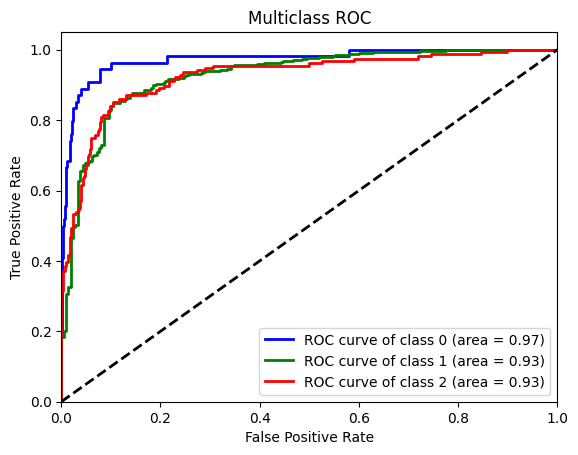

AUC for each class:
Class 0 (area = 0.97)
Class 1 (area = 0.93)
Class 2 (area = 0.93)
Macro-average AUC: 0.94
              precision    recall  f1-score   support

           0       0.73      0.87      0.80        54
           1       0.91      0.87      0.89       342
           2       0.78      0.81      0.80       156

    accuracy                           0.85       552
   macro avg       0.81      0.85      0.83       552
weighted avg       0.86      0.85      0.85       552



In [ ]:
# Evaluation
model.eval()
logits_list, true_labels = [], []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    logits_list.extend(logits)
    true_labels.extend(label_ids)

# Convert logits to probabilities for ROC AUC
softmax = torch.nn.Softmax(dim=1)
probs = softmax(torch.tensor(logits_list)).numpy()

# Binarize the labels for ROC AUC calculation
y_test_binarized = label_binarize(true_labels, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate macro-average ROC AUC
roc_auc["macro"] = roc_auc_score(y_test_binarized, probs, multi_class="ovr", average="macro")

# Plot ROC AUC curves
plt.figure()
colors = cycle(['blue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC')
plt.legend(loc="lower right")
plt.show()

# Print out all AUC scores
print("AUC for each class:")
for i in range(n_classes):
    print(f"Class {i} (area = {roc_auc[i]:0.2f})")
print(f"Macro-average AUC: {roc_auc['macro']:0.2f}")

# Extract original class names using LabelEncoder and convert to strings
original_class_names = label_encoder.inverse_transform([0, 1, 2])  # Make sure to adjust these indices based on your classes
original_class_names = [str(name) for name in original_class_names]  # Ensure names are strings

# Print classification report
report = classification_report(true_labels, probs.argmax(axis=-1), target_names=original_class_names)
print(report)


##roBERTa

In [ ]:
!pip install transformers torch

import pandas as pd
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encoding labels ('positive', 'negative', 'neutral') to numerical values
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])

# Tokenization and Data Preparation (using cleaned text)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
encoded_data = tokenizer.batch_encode_plus(
    df['cleaned_text'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=128,  # Adjust if your sentences are longer
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(df['label'].tolist())

# Split into training and testing sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    input_ids, labels, random_state=35476648, test_size=0.2
)
train_masks, test_masks, _, _ = train_test_split(
    attention_masks, input_ids, random_state=35476648, test_size=0.2
)

In [ ]:
# Create DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=32)

# Load Pre-trained Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3) # 3 labels for positive, negative, neutral

# Enable GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Fine-tune (Optimizer, Loss Function, Training Loop)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(3):  # Adjust number of epochs
    model.train()
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask)  # RoBERTa doesn't use token_type_ids

        loss = loss_fn(outputs.logits, b_labels)
        loss.backward()
        optimizer.step()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


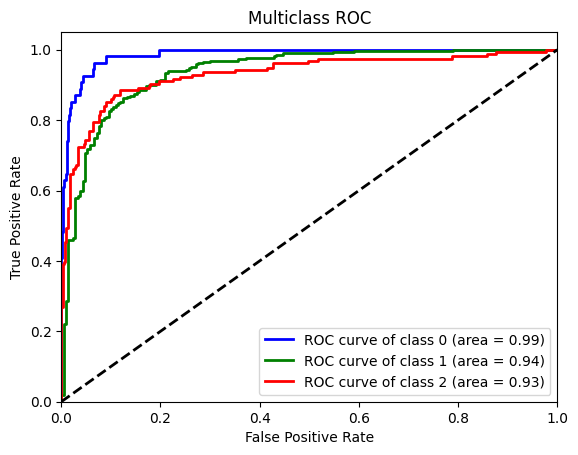

AUC for each class:
Class 0 (area = 0.99)
Class 1 (area = 0.94)
Class 2 (area = 0.93)
Macro-average AUC: 0.95
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        54
           1       0.88      0.93      0.90       342
           2       0.88      0.72      0.80       156

    accuracy                           0.87       552
   macro avg       0.84      0.84      0.84       552
weighted avg       0.87      0.87      0.86       552



In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Evaluation
model.eval()
logits_list, true_labels = [], []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    logits_list.extend(logits)
    true_labels.extend(label_ids)

# Convert logits to probabilities
softmax = torch.nn.Softmax(dim=1)
probs = softmax(torch.tensor(logits_list)).numpy()

# Binarize the labels and calculate ROC AUC
y_test_binarized = label_binarize(true_labels, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate macro-average ROC AUC
roc_auc["macro"] = roc_auc_score(y_test_binarized, probs, multi_class="ovr", average="macro")

# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC')
plt.legend(loc="lower right")
plt.show()

# Print out all AUC scores
print("AUC for each class:")
for i in range(n_classes):
    print(f"Class {i} (area = {roc_auc[i]:0.2f})")
print(f"Macro-average AUC: {roc_auc['macro']:0.2f}")

# Extract original class names using LabelEncoder and convert to strings
original_class_names = label_encoder.inverse_transform([0, 1, 2])  # Adjust these indices based on your classes
original_class_names = [str(name) for name in original_class_names]  # Ensure names are strings

# Print classification report
report = classification_report(true_labels, probs.argmax(axis=-1), target_names=original_class_names)
print(report)


## Tabulate


In [ ]:
import pandas as pd
from tabulate import tabulate

# Example data: replace this with your actual model metrics
data = [
    {"Model": "Logistic Regression", "Type": "Machine Learning", "Accuracy": 0.74, "Precision": 0.74, "Recall": 0.74, "F1-Score": 0.71, "ROC AUC Score": 0.85},
    {"Model": "SVM", "Type": "Machine Learning", "Accuracy": 0.76, "Precision": 0.75, "Recall": 0.76, "F1-Score": 0.75, "ROC AUC Score": 0.87},
    {"Model": "Random Forest", "Type": "Machine Learning", "Accuracy": 0.76, "Precision": 0.75, "Recall": 0.76, "F1-Score": 0.73, "ROC AUC Score": 0.83},
    {"Model": "CNN", "Type": "Deep Learning", "Accuracy": 0.76, "Precision": 0.75, "Recall": 0.76, "F1-Score": 0.75, "ROC AUC Score": 0.85},
    {"Model": "LSTM", "Type": "Deep Learning", "Accuracy": 0.66, "Precision": 0.68, "Recall": 0.66, "F1-Score": 0.67, "ROC AUC Score": 0.80},
    {"Model": "BiLSTM", "Type": "Deep Learning", "Accuracy": 0.63, "Precision": 0.64, "Recall": 0.63, "F1-Score": 0.64, "ROC AUC Score": 0.77},
    {"Model": "BERT", "Type": "Transformer Model", "Accuracy": 0.85, "Precision": 0.86, "Recall": 0.85, "F1-Score": 0.85, "ROC AUC Score": 0.94},
    {"Model": "RoBERTa", "Type": "Transformer Model", "Accuracy": 0.87, "Precision": 0.87, "Recall": 0.87, "F1-Score": 0.86, "ROC AUC Score": 0.95},
]

# Creating a DataFrame
df = pd.DataFrame(data)

# Optionally, fill NaN values with dashes if any
df.fillna('-', inplace=True)

# Display the table using tabulate
print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))


+---------------------+-------------------+------------+-------------+----------+------------+-----------------+
| Model               | Type              |   Accuracy |   Precision |   Recall |   F1-Score |   ROC AUC Score |
|---------------------+-------------------+------------+-------------+----------+------------+-----------------|
| Logistic Regression | Machine Learning  |       0.74 |        0.74 |     0.74 |       0.71 |            0.85 |
| SVM                 | Machine Learning  |       0.76 |        0.75 |     0.76 |       0.75 |            0.87 |
| Random Forest       | Machine Learning  |       0.76 |        0.75 |     0.76 |       0.73 |            0.83 |
| CNN                 | Deep Learning     |       0.76 |        0.75 |     0.76 |       0.75 |            0.85 |
| LSTM                | Deep Learning     |       0.66 |        0.68 |     0.66 |       0.67 |            0.8  |
| BiLSTM              | Deep Learning     |       0.63 |        0.64 |     0.63 |       0.64 |  